In [4]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch import optim
from torch.autograd import Variable

In [5]:
from torchvision import datasets,transforms
#root_dir = "/kaggle/input/flowers-recognition/flowers/flowers"
root_dir = "../input/flowers-recognition"
flower_transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
flower_dataset = datasets.ImageFolder(root_dir,transform=flower_transform)

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
is_cuda = False
if torch.cuda.is_available():
    is_cuda = True

In [7]:
index =  list(range(len(flower_dataset)))
import random
random.shuffle(index)
random.shuffle(index)
# for shuffling data
print(index[:50])

[622, 2266, 1279, 3375, 3800, 1963, 2066, 1014, 3349, 1851, 1789, 3078, 2976, 1037, 1868, 295, 1353, 1243, 4163, 1559, 2867, 922, 587, 3805, 4272, 70, 473, 1652, 2846, 1377, 331, 1027, 2260, 1419, 3895, 1066, 1982, 1908, 4246, 3955, 2108, 1129, 3934, 3701, 685, 2934, 1325, 3131, 1753, 2116]


In [8]:
test_indeces = int(np.ceil(len(flower_dataset)*0.1))
val_indeces = int(np.ceil(len(flower_dataset)*0.1))
train_indeces = int(np.ceil(len(flower_dataset)*0.80))
test_sampler = torch.utils.data.SubsetRandomSampler(index[:test_indeces])
val_sampler = torch.utils.data.SubsetRandomSampler(index[test_indeces:val_indeces+test_indeces])
train_sampler = torch.utils.data.SubsetRandomSampler(index[val_indeces+test_indeces:train_indeces])

In [9]:
test = torch.utils.data.DataLoader(flower_dataset,batch_size=32, sampler=test_sampler)
val = torch.utils.data.DataLoader(flower_dataset, batch_size=32, sampler=val_sampler)
train = torch.utils.data.DataLoader(flower_dataset,batch_size=32, sampler=train_sampler)

In [10]:
num_epochs = 10
num_classes = 5
learning_rate = 0.005

In [11]:
is_cuda = False
if torch.cuda.is_available():
    is_cuda = True

In [12]:
gnet = models.googlenet(pretrained=True)
gnet

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [13]:
gnet.fc = nn.Linear(1024, num_classes)
gnet = gnet.cuda()

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gnet.parameters(), lr=learning_rate)

In [15]:
import torch.nn.functional as F
def fit(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    l=433
    for batch_idx , (data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.cuda(),target.cuda()
        data , target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            l=3457
            optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output,target)
        
        running_loss += F.cross_entropy(output,target,size_average=False).item()
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct/l
    
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{l}{accuracy:{10}.{4}}')
    return loss,accuracy

In [16]:
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,10):
    epoch_loss, epoch_accuracy = fit(epoch,gnet,train,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,gnet,val,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

/opt/conda/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


training loss is 0.014 and training accuracy is 2560/3457     74.05
validation loss is   0.0 and validation accuracy is 432/433     99.77
training loss is   0.0 and training accuracy is 2590/3457     74.92
validation loss is   0.0 and validation accuracy is 432/433     99.77
training loss is   0.0 and training accuracy is 2590/3457     74.92
validation loss is   0.0 and validation accuracy is 432/433     99.77
training loss is   0.0 and training accuracy is 2590/3457     74.92
validation loss is   0.0 and validation accuracy is 432/433     99.77
training loss is   0.0 and training accuracy is 2590/3457     74.92
validation loss is   0.0 and validation accuracy is 432/433     99.77
training loss is   0.0 and training accuracy is 2590/3457     74.92
validation loss is   0.0 and validation accuracy is 432/433     99.77
training loss is   0.0 and training accuracy is 2590/3457     74.92
validation loss is   0.0 and validation accuracy is 432/433     99.77
training loss is   0.0 and trainin

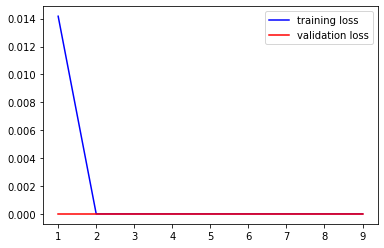

In [17]:
import matplotlib.pyplot as plt
plt.plot(range(1,len(train_losses)+1),train_losses,'b',label = 'training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
plt.legend()

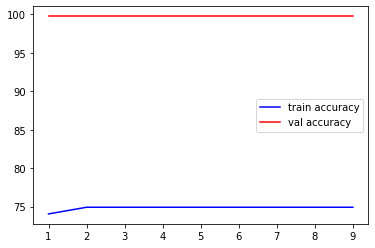

In [18]:
plt.plot(range(1,len(train_accuracy)+1),train_accuracy,'b',label = 'train accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,'r',label = 'val accuracy')
plt.legend()

In [19]:
gnet.eval()  
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test:
        images = images.to(device)
        labels = labels.to(device)
        outputs = gnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 100.0 %
